# Welcome
Please note that this is not a Python tutorial. We assume that you are aware of basic Python coding and concepts including the use of ``conda`` and ``pip``. If you did not install pyfar already please do so by running the command

``pip install mesh2scattering``

Note that this notebook do the same as the demo.py, so its up to you what you prefer.

After this go to your Python editor of choice and import mesh2scattering


In [1]:
import mesh2scattering as m2s
import pyfar as pf
import os
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import sofar as sf

# create the project

we need to set the paths for the meshes. First for the sample and then for the reference plate. Please notice that the sample should lay on the x-y-plane where z is the hight.

In [2]:
sample_path = os.path.join('meshes', 'reference_n10_1', 'sample.stl')
reference_path = os.path.join('meshes', 'reference_n10_1', 'sample.stl')
project_path = os.path.join(os.getcwd(), 'project_impedance')
if not os.path.isdir(project_path):
    os.mkdir(project_path)

Define the frequency array. For simplicity we just use 3 frequencies. 
If you want to create 3rd- or 1st octave band frequencies have a look on ``pyfar.dsp.filter.fractional_octave_frequencies``.

In [3]:
frequencies = np.array([1000, 2000, 3000, 4000])

Now we need to define the source and receiver positions. Therefore we create a sampling grid, including the pole and removing the lower part of the grid.

/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_79165/1083505973.py:2: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  receiverPoints = pf.samplings.sph_gaussian(
/Users/anne/miniconda3/envs/mesh2scattering/lib/python3.13/site-packages/pyfar/samplings/samplings.py:344: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  sampling = pyfar.Coordinates(
/Users/anne/miniconda3/envs/mesh2scattering/lib/python3.13/site-packages/pyfar/classes/coordinates.py:265: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  self.sh_order = sh_order
/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_79165/1083505973.py:4: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.calculate_sampling_weights.'
  receiverPoints.weights = pf.samplings.calculate_sph_voro

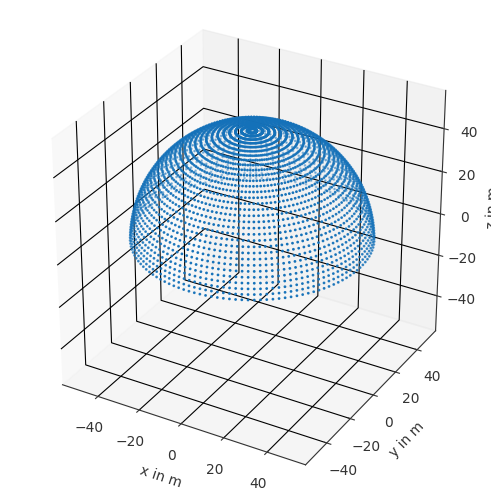

In [4]:
receiver_radius = 50
receiverPoints = pf.samplings.sph_gaussian(
    sh_order=63, radius=receiver_radius)
receiverPoints.weights = pf.samplings.calculate_sph_voronoi_weights(
    receiverPoints)
receiverPoints = receiverPoints[receiverPoints.colatitude < np.pi/2]
receiverPoints.show()
plt.show()

The receiver positions can now go into its related class. The class requires faces, but they can be simply calcualted by the class by using ``from_spherical``.

In [5]:
evaluation_grid = m2s.input.EvaluationGrid.from_spherical(
    receiverPoints, 'grid')

Same for the source positions. The radius is set to 10 according to the diffusion ISO Standard 17497-2.

/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_79165/3453968436.py:3: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.equal_angle.'
  sourcePoints = pf.samplings.sph_equal_angle(


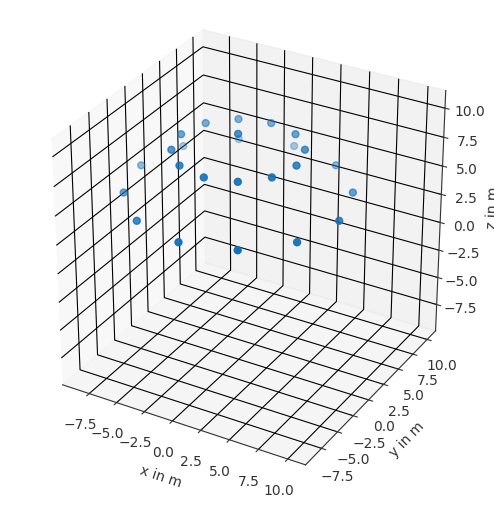

In [6]:
source_delta_deg = 30
source_radius = 10
sourcePoints = pf.samplings.sph_equal_angle(
    source_delta_deg, source_radius)
sourcePoints = sourcePoints[sourcePoints.colatitude < np.pi/2]
sourcePoints.weights = np.cos(sourcePoints.elevation)
sourcePoints.show()
plt.show()

Now we need to set the parameters of the sample. 

In [7]:
structural_wavelength = 0.177/2.5
sample_diameter = 0.8
model_scale = 2.5
sample_baseplate_hight = 0.01

Furthermore we need to define the symmetry properties of the sample. In our case we have a sine-shaped surface, so the sample is symmetrical to the x-axe and y-axe, therefore we set the ``symmetry_azimuth`` to 90 and 180 degree. A rotational symmetry is not give, so we set it to ``False``.

In [8]:
symmetry_azimuth = [90, 180]
symmetry_rotational = False

Lets collect all the metadata of the sample and the surface into the related class object.
The meta data will not influence the simulation or postprocessing, they are just collected and exported in the sofa file at the end.

In [9]:
impedance_description = m2s.input.SurfaceDescription(
    structural_wavelength_x=0,
    structural_wavelength_y=0,
    structural_depth=0,
    surface_type=m2s.input.SurfaceType.PERIODIC,
    symmetry_azimuth=symmetry_azimuth,
    symmetry_rotational=symmetry_rotational,
)
sample_mesh = trimesh.load(sample_path)
n_faces = sample_mesh.faces.shape[0]
impedance = 0.5
R = (impedance-1)/(impedance+1)
alpha = 1/(1+R**2)
print(f'Z: {impedance}; alpha: {alpha}, R: {R}')
bc = m2s.input.bc.BoundaryCondition(
    0.5,
    m2s.input.bc.BoundaryConditionType.impedance,
)
dot = np.dot(sample_mesh.face_normals, np.array([0, 0, 1]))
indexes = np.where(dot < 1e-14)
if np.min(indexes[0]) != 0 or np.max(indexes[0]) != len(indexes)-1:
    print('Something went wrong.')
bcm = m2s.input.bc.BoundaryConditionMapping(n_faces)
bcm.apply_material(
    bc, 0, int(indexes[0][-1]), # Apply to upper surface
)

mesh_impedance = m2s.input.SampleMesh(
    mesh=sample_mesh,
    surface_description=impedance_description,
    sample_baseplate_hight=0.01,
    sample_diameter=sample_diameter,
    sample_shape=m2s.input.SampleShape.ROUND,
    bc_mapping=bcm,
)
reference_description = m2s.input.SurfaceDescription(
    structural_wavelength_x=0,
    structural_wavelength_y=0,
    structural_depth=0,
    surface_type=m2s.input.SurfaceType.FLAT,
    symmetry_azimuth=[],
    symmetry_rotational=True,
)
mesh = trimesh.load(reference_path)

mesh_reference = m2s.input.SampleMesh(
    mesh=mesh,
    surface_description=reference_description,
    sample_baseplate_hight=0.01,
    sample_diameter=sample_diameter,
    sample_shape=m2s.input.SampleShape.ROUND,
)

Z: 0.5; alpha: 0.8999999999999999, R: -0.3333333333333333
Something went wrong.


This symmetry settings are required for the postprocessing and and we can speed up our simulating by skipping incident angles and calculate them in the postprocessing by mirroring the existing data. Therefore we can skip the azimuth angles grater than 90 degree for the source positions.

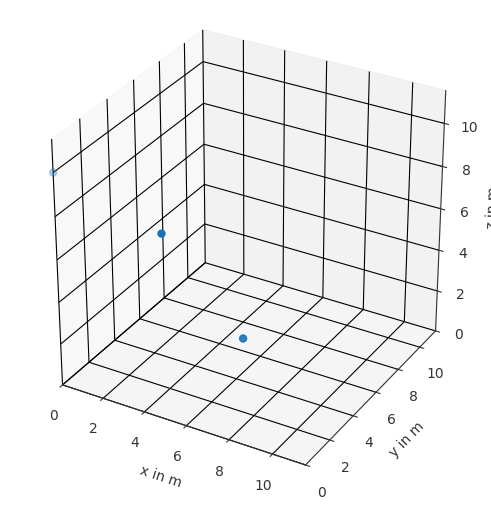

[ 0. 30. 60.]


In [10]:
sourcePoints_reduced = sourcePoints[sourcePoints.azimuth <= np.pi/2]
sourcePoints_reduced = sourcePoints[sourcePoints.azimuth == 0]
sourcePoints_reduced.show()
plt.show()
print(sourcePoints_reduced.colatitude*180/np.pi)

Now we can add put the source positions into the correct class formate. We will define Plane waves.

In [11]:
sourcePoints_reduced.cartesian *= -1
sound_sources = m2s.input.SoundSource(
    source_coordinates=sourcePoints_reduced,
    source_type=m2s.input.SoundSourceType.PLANE_WAVE,
)

let's plot the scene

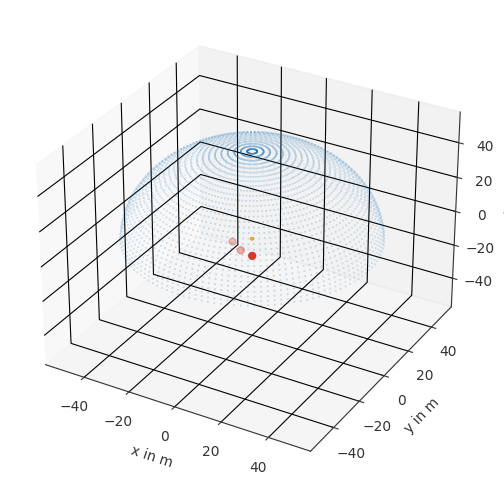

In [12]:
sample = trimesh.load_mesh(sample_path).vertices
sample_coords = pf.Coordinates(sample[:, 0],sample[:, 1],sample[:, 2])
ax = pf.plot.scatter(receiverPoints, s=1/20)
pf.plot.scatter(sourcePoints_reduced, ax=ax)
pf.plot.scatter(sample_coords, ax=ax, s=1/72)
plt.show()


Now we can create the project. Please notice that the project was already created and simulated for demo.

In [13]:
m2s.input.write_scattering_project_numcalc(
    project_path=os.path.join(project_path, 'impedance'),
    project_title='impedance',
    frequencies=frequencies,
    sound_sources=sound_sources,
    evaluation_grids=[evaluation_grid],
    sample_mesh=mesh_impedance,
    )
m2s.input.write_scattering_project_numcalc(
    project_path=os.path.join(project_path, 'reference'),
    project_title='reference',
    frequencies=frequencies,
    sound_sources=sound_sources,
    evaluation_grids=[evaluation_grid],
    sample_mesh=mesh_reference,
    )

# run project
To execute the project you need to build the ``NumCalc`` project. If you use Windows, the exe can be directly downloaded and on mac or linux it can be build, see the function documentation for more information.

In [14]:
numcalc_path = m2s.numcalc.build_or_fetch_numcalc()

Now we can run the simulation, this may take some time. This example is already simulated so we don't need to wait. If we don't explicitly define then ``numcalc_path`` it will use ``m2s.numcalc.build_or_fetch_numcalc()`` in the background to determine the numcalc_path.

In [15]:
m2s.numcalc.manage_numcalc(
    os.path.join(os.getcwd(), project_path), wait_time=1)


Starting manage_numcalc with the following arguments [Jun 04 2025, 18:49:50]
----------------------------------------------------------------------------
project_path: /Users/anne/git/_pyfar/Mesh2scattering/examples/project_impedance
numcalc_path: /Users/anne/git/_pyfar/Mesh2scattering/mesh2scattering/numcalc/bin/NumCalc
max_ram_load: 16.00 GB (16.00 GB detected, 5.44 GB available)
ram_safety_factor: 1.05
max_cpu_load: 90 %
max_instances: 8 (8 cores detected)
wait_time: 1 seconds
starting_order: alternate
confirm_errors: False


Per project summary of instances that will be run
-------------------------------------------------
Detected 2 NumCalc projects in
/Users/anne/git/_pyfar/Mesh2scattering/examples/project_impedance

Obtaining RAM estimates for /Users/anne/git/_pyfar/Mesh2scattering/examples/project_impedance/impedance/NumCalc/source_1
Obtaining RAM estimates for /Users/anne/git/_pyfar/Mesh2scattering/examples/project_impedance/impedance/NumCalc/source_2
Obtaining RAM estimates 

# Post processing
Now we need to create the scattering pattern sofa files out of the simulation results. Here the symmetry is also applied. since the reference sample is always rotational symmetric, the data for the missing angles are rotated in this was sample and reference  data will have the same dimensions and coordinate

In [16]:
m2s.output.write_pressure(os.path.join(project_path, 'impedance'))
m2s.output.write_pressure(os.path.join(project_path, 'reference'))


 Writing the project report ...

 Writing the project report ...


calculate the scattering coefficient for each incident angle and the random one from the scattering pattern

In [17]:
m2s.process.calculate_scattering(
    os.path.join(project_path, 'impedance_grid.pressure.sofa'),
    os.path.join(project_path, 'reference_grid.pressure.sofa'),
    'impedance',
    )

SOFA file contained custom entries
----------------------------------
OriginalFrequencies, RealScaleFrequencies, Lbyl, SampleStructuralWavelength, SampleStructuralWavelengthX, SampleStructuralWavelengthY, SampleModelScale, SampleDiameter, SpeedOfSound, DensityOfMedium, ReceiverWeights, SourceWeights, SampleSymmetryAzimuth, SampleSymmetryRotational
SOFA file contained custom entries
----------------------------------
OriginalFrequencies, RealScaleFrequencies, Lbyl, SampleStructuralWavelength, SampleStructuralWavelengthX, SampleStructuralWavelengthY, SampleModelScale, SampleDiameter, SpeedOfSound, DensityOfMedium, ReceiverWeights, SourceWeights, SampleSymmetryAzimuth, SampleSymmetryRotational


# Read and plot data
example of plotting the scattering coefficient

In [19]:
# calculate r_spec after Mommertz 
imp_sofa = sf.read_sofa(
    os.path.join(project_path, 'impedance_grid.pressure.sofa'))
har_sofa =sf.read_sofa(
    os.path.join(project_path, 'reference_grid.pressure.sofa'))
imp, sources_imp, receivers_imp = pf.io.convert_sofa(imp_sofa)
har, sources_har, receivers_har = pf.io.convert_sofa(har_sofa)
sources_imp.weights = imp_sofa.SourceWeights
receivers_imp.weights = imp_sofa.ReceiverWeights
sources_har.weights = har_sofa.SourceWeights
receivers_har.weights = har_sofa.ReceiverWeights


SOFA file contained custom entries
----------------------------------
OriginalFrequencies, RealScaleFrequencies, Lbyl, SampleStructuralWavelength, SampleStructuralWavelengthX, SampleStructuralWavelengthY, SampleModelScale, SampleDiameter, SpeedOfSound, DensityOfMedium, ReceiverWeights, SourceWeights, SampleSymmetryAzimuth, SampleSymmetryRotational
SOFA file contained custom entries
----------------------------------
OriginalFrequencies, RealScaleFrequencies, Lbyl, SampleStructuralWavelength, SampleStructuralWavelengthX, SampleStructuralWavelengthY, SampleModelScale, SampleDiameter, SpeedOfSound, DensityOfMedium, ReceiverWeights, SourceWeights, SampleSymmetryAzimuth, SampleSymmetryRotational


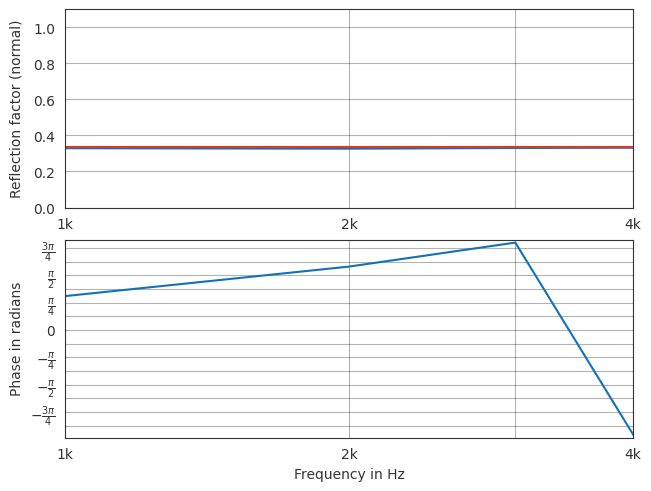

In [20]:
weights = receivers_imp.weights[..., np.newaxis]
p_corr = np.sum(imp.freq*np.conj(har.freq)*weights, axis=-2)
p_0_sqare = np.sum(har.freq**2 * weights, axis=-2)
r_spec = pf.FrequencyData(p_corr / p_0_sqare, har.frequencies)
r_analytical = pf.FrequencyData(
    np.ones_like(har.frequencies)*R, har.frequencies)

pf.plot.freq_phase(r_spec[0], dB=False, label='r_spec normal incidence')
ax = pf.plot.freq_phase(
    r_analytical, dB=False, label='analytical normal incidence')
ax[0].set_ylim(0, 1.1)
ax[0].set_ylabel('Reflection factor (normal)')
plt.show()


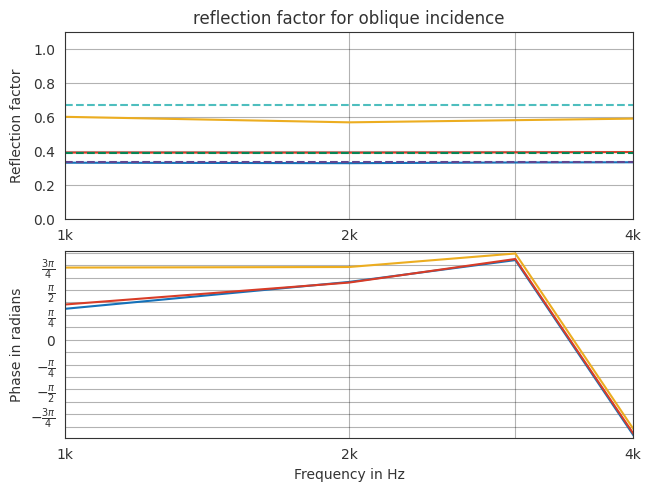

In [21]:
# for oblique incidence
theta = sources_imp.colatitude
pf.plot.freq_phase(r_spec, dB=False, label='r_spec normal incidence')
ax = pf.plot.freq_phase(
    r_analytical/np.cos(theta), dB=False, label='analytical normal incidence',
    linestyle='--')
ax[0].set_ylim(0, 1.1)
ax[0].set_ylabel('Reflection factor')
ax[0].set_title('reflection factor for oblique incidence')
plt.show()
